# Project Natural Computing

First we add some imports that are needed

In [113]:
import numpy as np
from copy import deepcopy
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

Next, we define the activation functions. There is a choice between ReLu, Sigmoid and SoftMax

In [29]:
def ReLU(mat):
    return mat * (mat > 0)

def Sigmoid(mat):
    return 1/(1 + np.exp(-mat))

def SoftMax(mat):
    exp_mat = np.exp(mat)
    return exp_mat/np.sum(exp_mat, axis = 1, keepdims = True)

Next, we have a network class which contains the number of layer, activation function, weights, biases and current fitness.

The forward function pushes the samples through the current network and returns the return values.

In [30]:
class Network:
    def __init__(self, node_seq, activation_functions, Xavier = True):
        self.node_seq = node_seq
        self.num_layers = len(node_seq) - 1
        self.activation = activation_functions
        self.weight_mats = []
        self.bias_vecs = []
        self.fitness = 0
        for idx in range(self.num_layers):
            n_in = node_seq[idx]
            n_out = node_seq[idx + 1]
              # use Xavier initialization
            bound = np.sqrt(6/(n_in + n_out))
            if Xavier:
                self.weight_mats.append(np.random.uniform(-bound, bound, size = (n_in, n_out)))
            else: 
                self.weight_mats.append(np.zeros((n_in, n_out)))
            self.bias_vecs.append(np.zeros(n_out))
            
    def forward(self, samples):
        # note: give inputs in the form (samples, features)
        for idx in range(self.num_layers):
            samples = self.activation[idx](samples @ self.weight_mats[idx] + self.bias_vecs[idx])
        return samples
        
#net = Network([2,2,2], [ReLU, SoftMax])
#net.forward(np.array([[0,0], [0,1], [1,0], [1,1]]))[range(4), [1,0,1,0]]

The next block defines several fitness functions

In [37]:
def cross_entropy_fitness(correct, predict):
    return max(np.sum(np.log(predict[range(predict.shape[0]), correct])) + predict.shape[0], 0)

  # computes fitness based on xor of all binary sequences of a given length
def xor_fitness(net, inputs, outputs):
    predict = net.forward(inputs)
    return cross_entropy_fitness(outputs, predict)

def xor_all_fitness(net, inputs, outputs):
    predict = net.forward(inputs)
    return np.log(predict[range(predict.shape[0]), outputs])

In this section, we define crossover and mutation operators

In [38]:
def crossover_minimax(net1, net2):
    node_seq = net1.node_seq
    activation = net1.activation
    new_net1 = Network(node_seq, activation, Xavier = False)
    new_net2 = Network(node_seq, activation, Xavier = False)
    for idx in range(net1.num_layers): #perhaps random choice, instead of one net all minima and one net all maxima
        new_net1.weight_mats[idx] = np.minimum(net1.weight_mats[idx], net2.weight_mats[idx])
        new_net2.weight_mats[idx] = np.maximum(net1.weight_mats[idx], net2.weight_mats[idx])
        new_net1.bias_vecs[idx] = np.minimum(net1.bias_vecs[idx], net2.bias_vecs[idx])
        new_net2.bias_vecs[idx] = np.maximum(net1.bias_vecs[idx], net2.bias_vecs[idx])
    return new_net1, new_net2
    
def crossover_layer(net1, net2):
    node_seq = net1.node_seq
    activation = net1.activation
    new_net1 = Network(node_seq, activation, Xavier = False)
    new_net2 = Network(node_seq, activation, Xavier = False)
    select_layers = np.random.uniform(size = net1.num_layers)
    for idx in range(net1.num_layers): 
        if select_layers[idx] < 0.5:
            new_net1.weight_mats[idx] = net1.weight_mats[idx]
            new_net2.weight_mats[idx] = net2.weight_mats[idx]
            new_net1.bias_vecs[idx] = net1.bias_vecs[idx]
            new_net2.bias_vecs[idx] = net2.bias_vecs[idx]
        else:
            new_net1.weight_mats[idx] = net2.weight_mats[idx]
            new_net2.weight_mats[idx] = net1.weight_mats[idx]
            new_net1.bias_vecs[idx] = net2.bias_vecs[idx]
            new_net2.bias_vecs[idx] = net1.bias_vecs[idx]
    return new_net1, new_net2
    
def mut_layer(net):
    mut_size = np.random.uniform()
    select_layers = np.random.uniform(size = net.num_layers)
    for idx in range(net.num_layers): 
        if select_layers[idx] < 0.5:
            n_in = net.node_seq[idx]
            n_out = net.node_seq[idx + 1]
            bound = np.sqrt(6/(n_in + n_out)) * mut_size
            net.weight_mats[idx] += np.random.uniform(-bound, bound, size = (n_in, n_out))
            net.bias_vecs[idx] += np.random.uniform(-bound, bound, size = n_out)

def mut_index(net):
    mut_size = np.random.uniform()
    idx = int(np.random.choice(net.num_layers, 1))
    n_in = net.node_seq[idx]
    n_out = net.node_seq[idx + 1]
    idx2 = int(np.random.choice(n_in, 1))
    idx3 = int(np.random.choice(n_out, 1))
    bound = np.sqrt(6/(n_in + n_out)) * mut_size
    net.weight_mats[idx][idx2][idx3] += np.random.uniform(-bound, bound, size = 1)


The class Genetic defines the neuroevolution algorithm

In [50]:
class Genetic:
    def __init__(self, pop_size, node_seq, activation_functions, fitness_function, 
                 inp, outp,
                 mutation_functions, mutation_probabilities, 
                 crossover_functions, crossover_probabilities, elite):
        self.net_list = []
        self.pop_size = pop_size
        for idx in range(pop_size):
            self.net_list.append(Network(node_seq, activation_functions))
        
        self.fitness_func = fitness_function
        self.inp = inp
        self.outp = outp
        self.mutation_func = mutation_functions
        self.mutation_threshold = np.cumsum(mutation_probabilities)
        self.crossover_func = crossover_functions
        self.crossover_threshold = np.cumsum(crossover_probabilities)
        self.elite = elite
        self.current_best_fitness = 0
        self.hist = []
        
    def next_generation(self):
        new_net_idx = np.random.permutation(self.pop_size)
        new_net_list = [deepcopy(self.net_list[idx]) for idx in new_net_idx]
        
        select_mutate = np.random.uniform(size=self.pop_size)
        for idx in range(self.pop_size):
            for mut_idx in range(len(self.mutation_func)):
                if select_mutate[idx] < self.mutation_threshold[mut_idx]:
                    self.mutation_func[mut_idx](new_net_list[idx])
                    break #breaks from this generation, but many generations still executed
                    
        cross_net_idx = np.random.permutation(self.pop_size)
        cross_net_list = [deepcopy(self.net_list[idx]) for idx in cross_net_idx]
        select_cross = np.random.uniform(size = self.pop_size)
        for idx in range(self.pop_size//2):
            for cross_idx in range(len(self.crossover_func)):
                if select_cross[idx] < self.crossover_threshold[cross_idx]:
                    cross_net_list[2*idx], cross_net_list[2*idx + 1] =  \
                      self.crossover_func[cross_idx](cross_net_list[2*idx], \
                                                     cross_net_list[2*idx + 1])
                    
        new_net_list.extend(cross_net_list)
        new_net_list.extend(self.net_list)
        for net in new_net_list:
            net.fitness = self.fitness_func(net, self.inp, self.outp)
        
        new_net_list.sort(key = lambda x: -x.fitness)
        fitnesses = [net.fitness for net in new_net_list]
        probabilities = fitnesses / np.sum(fitnesses)
        net_idx = np.random.choice(len(new_net_list), self.pop_size - self.elite, p = probabilities)
        self.net_list = [new_net_list[idx] for idx in net_idx]
        self.net_list.extend(new_net_list[:self.elite])

        self.net_list.sort(key = lambda x: -x.fitness)
        if self.net_list[0].fitness > 0.0001 + self.current_best_fitness:
            self.current_best_fitness = self.net_list[0].fitness
            self.hist.append(self.net_list[0].fitness)

# Testing XOR

In [55]:
seq_lengths = [2, 4]
all_hists = []
for seq_len in seq_lengths:
    inputs = [[(num >> idx) % 2 for idx in range(seq_len)] for num in range(2**seq_len)]
    outputs = [sum(seq) % 2 for seq in inputs]


    genetic_algo = Genetic(50, [seq_len, 20, 2], [ReLU, SoftMax], xor_fitness, 
                            inputs, outputs,
                            [mut_layer, mut_index], [0.5, 0.5], 
                            [crossover_minimax, crossover_layer], [0.5, 0.5], 1)
    for gen in range(1500):
        genetic_algo.next_generation()
    opt_net = genetic_algo.net_list[0]
    xor_all_fitness(opt_net, inputs, outputs)
    fitnesses = genetic_algo.hist
    all_hists.append(fitnesses)

#opt_net.forward([[0,0,0,0]])

In [60]:
seq_len = 16
inputs = [[(num >> idx) % 2 for idx in range(seq_len)] for num in range(2**seq_len)][:50]
outputs = [sum(seq) % 2 for seq in inputs][:50]

genetic_algo = Genetic(50, [seq_len, 20, 2], [ReLU, SoftMax], xor_fitness, 
                        inputs, outputs,
                        [mut_layer, mut_index], [0.5, 0.5], 
                        [crossover_minimax, crossover_layer], [0.5, 0.5], 1)
for gen in range(6000):
    genetic_algo.next_generation()
opt_net = genetic_algo.net_list[0]
xor_all_fitness(opt_net, inputs, outputs)
fitnesses = genetic_algo.hist
all_hists.append(fitnesses)

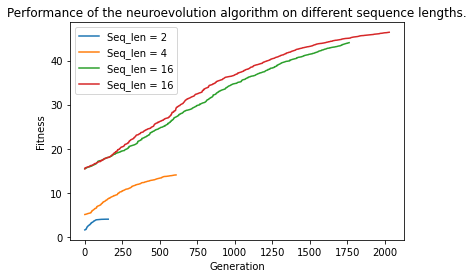

In [61]:
seq_lengths.append(16)
for i in range(0, len(seq_lengths)):
    plt.plot(range(0,len(all_hists[i])), all_hists[i], label = "Seq_len = " + str(seq_lengths[i]))
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.title("Performance of the neuroevolution algorithm on different sequence lengths.")
plt.show()

# IRIS

In [94]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
#from sklearn.datasets import fetch_mldata

In [95]:
iris = datasets.load_iris()
x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)
print(np.shape(x_train))
print(np.shape(x_test))

(150, 4)
(150,)
(100, 4)


In [145]:
genetic_algo = Genetic(50, [4, 20, 3], [ReLU, SoftMax], xor_fitness, 
                        x_train, y_train,
                        [mut_layer, mut_index], [0.5, 0.5], 
                        [crossover_minimax, crossover_layer], [0.5, 0.5], 1)
for gen in range(200):
    genetic_algo.next_generation()
opt_net = genetic_algo.net_list[0]
xor_all_fitness(opt_net, x_train, y_train)
fitnesses = genetic_algo.hist

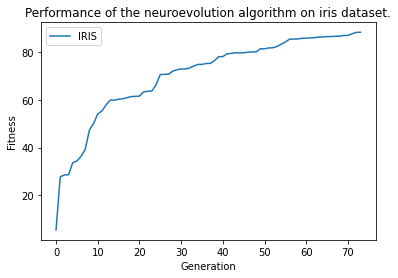

In [146]:
plt.plot(range(0,len(fitnesses)), fitnesses, label = "IRIS")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.title("Performance of the neuroevolution algorithm on iris dataset.")
plt.show()

In [147]:
predict = opt_net.forward(x_test)
predicted = [np.argmax(x) for x in predict]
acc = metrics.accuracy_score(y_test, predicted)
print(acc)

0.96


With about 10 generations, we found an accuracy of around 80%. When the number of generations is increased to 200, we can almost always reach an accuracy > 95%.

# MNIST

In [150]:
from sklearn.datasets import load_digits

In [151]:
mnist = load_digits()

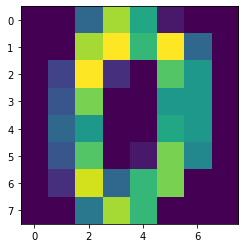

In [152]:
plt.imshow(mnist.images[0]);

In [157]:
x_train, x_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.33, random_state=42)

print(np.shape(x_train))
print(np.shape(x_test))

(1203, 64)
(594, 64)


In [165]:
genetic_algo = Genetic(50, [64, 20, 10], [ReLU, SoftMax], xor_fitness, 
                        x_train, y_train,
                        [mut_layer, mut_index], [0.5, 0.5], 
                        [crossover_minimax, crossover_layer], [0.5, 0.5], 1)
for gen in range(10):
    genetic_algo.next_generation()
opt_net = genetic_algo.net_list[0]
xor_all_fitness(opt_net, x_train, y_train)
fitnesses = genetic_algo.hist

c:\users\loesk\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


ValueError: probabilities contain NaN

In [ ]:
plt.plot(range(0,len(fitnesses)), fitnesses, label = "IRIS")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.title("Performance of the neuroevolution algorithm on iris dataset.")
plt.show()

In [ ]:
predict = opt_net.forward(x_test)
predicted = [np.argmax(x) for x in predict]
acc = metrics.accuracy_score(y_test, predicted)
print(acc)